In [17]:
#imports
from pathlib import Path

#file paths
ROOT = ROOT = Path.cwd().parent
RAW_DIR = ROOT/"data"/"raw"
PROCESSED_DIR = ROOT/"data"/"processed"

import sys, os
import pandas as pd
import numpy as np

sys.path.insert(0, os.path.abspath("..")) #preprocess at root
from preprocess import load_csv, save_csv, kmeans_plus_plus

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("Imports loaded")

Imports loaded


In [18]:
#1.1 load data
"""
Data cleaned in previous assignments. Load cleaned data directly
Cleaned data contains:
    NaN filled with 0
    regex normalization (spaces, lowercase,etc)
    churn to binary (1=churn, 0=not)
"""

df_clean = load_csv(PROCESSED_DIR, "data03_cleaned.csv")
total_charges = pd.to_numeric(df_clean.totalcharges, errors='coerce') #reconvert data type. pandas infers incorrectly from csv

print("Data")
display(df_clean.head().T) #transpose rows/cols to make viewing easier
print("\nDataTypes:")
display(df_clean.dtypes)

Loaded data03_cleaned.csv: length: 7043 

Data


,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no



DataTypes:


customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [19]:
#1.2 split features 'X' and target 'y' (churn=1 or not-churn=0). KMeans only applied to features
y = df_clean['churn'].values #target

df_features = df_clean.drop(['customerid', 'churn'], axis=1) #drop id and target

df_features.head().T

,0,1,2,3,4
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no
onlinebackup,yes,no,yes,no,no


In [20]:
#1.3 Build original full feature set 'X' with one-hot encoded values
#1.3.1 turn feature df int list of dicts (1 dict per row) for DictVectorizer to use
feature_dicts = df_features.to_dict(orient='records')
print("First element of dictionary:")
display(feature_dicts[0])

#1.3.2 create and fit DectVectorizer (convert to one-hot encode)
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(feature_dicts) #build list of categoires and column mappings (fit) + one-hot encode and apply to full feature set (transform)

print("\nShape of X (samples, features):", X.shape)
print("\nFirst row of X:")
display(X[0])

print("\nNames of columns after one-hot encoding:")
display(dv.get_feature_names_out())

First element of dictionary:


{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'no',
 'tenure': 1,
 'phoneservice': 'no',
 'multiplelines': 'no_phone_service',
 'internetservice': 'dsl',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'no',
 'streamingmovies': 'no',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'monthlycharges': 29.85,
 'totalcharges': 29.85}


Shape of X (samples, features): (7043, 45)

First row of X:


array([ 1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,
        0.  ,  1.  ,  0.  ,  0.  , 29.85,  0.  ,  1.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,
        0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,
        0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  , 29.85])


Names of columns after one-hot encoding:


array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [21]:
#1.4 Standardize data (mean 0, std dev 1)
scaler = StandardScaler()

#calculate mean and standard deviation (fit) and apply z-score
X_scaled = scaler.fit_transform(X) #full feature set z-scored

print("Shape ('n' X 'm'):", X_scaled.shape)

Shape ('n' X 'm'): (7043, 45)


In [29]:
#2.1 Manual KMeans
#2.1.1 Pick starting centroid (k)
"""
notes
axis=0: operate column wise. 
for a cluster: produce once centroid vector whre each element is methe mean for that feature
axis=1: operate row wise.
for distance: produce 1d arrays of distances, one per data point
for
"""

X_manual = X_scaled #clearly separate feature set for manual KMeans

k = 2 #starting centroid
np.random.seed(1)

#randomly pick k rows from feature set as intial centroid
initial_idx = np.random.choice(X_manual.shape[0], size=k, replace=False)
centroids = X_manual[initial_idx]

print("Initial centroid indices", initial_idx)
print("Centroid shape:", centroids.shape)

#2.1.2 create associated clusters. compute distance (d) from each point to each centroid
distances = np.stack(
    [np.linalg.norm(X_manual - centroids[j], axis=1) for j in range(k)],
    axis=1
)

#assign each point to closest centroid
labels_manual = np.argmin(distances, axis=1) 

print("\nCluster label counts:")
print(pd.Series(labels_manual).value_counts())

Initial centroid indices [3381 6180]
Centroid shape: (2, 45)

Cluster label counts:
0    4287
1    2756
Name: count, dtype: int64


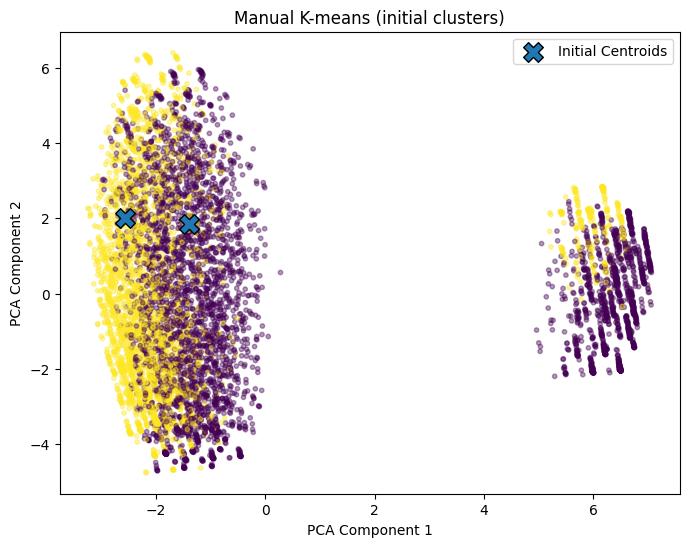

In [30]:
#2.2 Plot Centroids
"""
Notes:
Initial assignment of randomly chosen centroids
Colors are clusters (0 and 1, stored in labels_manual)
blobs do not represent centroids, they are PCA structures showing how the data spreads when compressed to 2D
"""
#2.2.1 reduce to 2 dimensions to visually polot
pca = PCA(n_components=2, random_state=1)
X_2d = pca.fit_transform(X_manual)

#2.2.2 transform centroids into PCA space
centroids_2d = pca.transform(centroids)

#2.2.3 plot
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_manual, alpha=0.4, s=10)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], 
            marker='X', 
            s=200, 
            edgecolor='black',
            label='Initial Centroids'
)

plt.title("Manual K-means (initial clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

Original centroids shape: (2, 45)
New centroids shape: (2, 45)


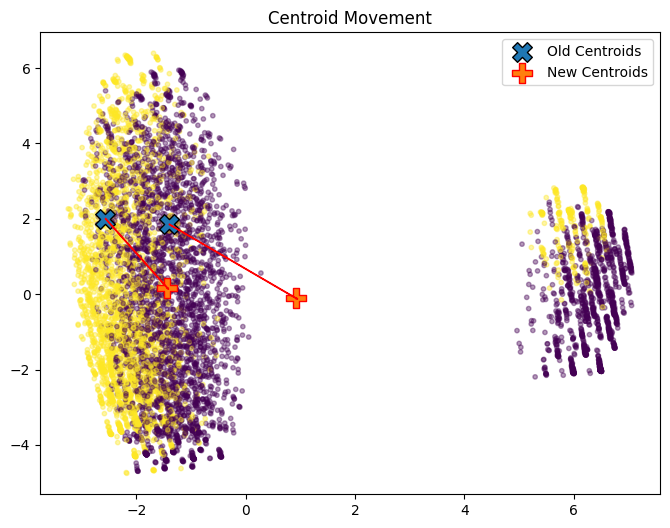

In [31]:
#2.3 recompute centroids as averages of assigned clusters
centroids_new = np.array([
    X_manual[labels_manual == j].mean(axis=0)
    for j in range(k)
])

print("Original centroids shape:", centroids.shape)
print("New centroids shape:", centroids_new.shape)

#plot
#project new centroids into PCA 2D space
centroids_new_2d = pca.transform(centroids_new)

plt.figure(figsize=(8,6))

#plot all points (colored by initial labels)
plt.scatter(X_2d[:,0], X_2d[:,1], 
            c=labels_manual, alpha=0.4, s=10)

#plot original centroids
plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
            marker='X', s=200, edgecolor='black',
            label="Old Centroids")

#plot new centroids
plt.scatter(centroids_new_2d[:,0], centroids_new_2d[:,1],
            marker='P', s=200, edgecolor='red',
            label="New Centroids")

#draw arrows showing movement
for i in range(k):
    plt.arrow(centroids_2d[i,0], centroids_2d[i,1],
              centroids_new_2d[i,0] - centroids_2d[i,0],
              centroids_new_2d[i,1] - centroids_2d[i,1],
              color='red', width=0.01)

plt.title("Centroid Movement")
plt.legend()
plt.show()

Cluster sizes after recomputing centroids:
1    3538
0    3505
Name: count, dtype: int64

Number of points that changed clusters: 1440


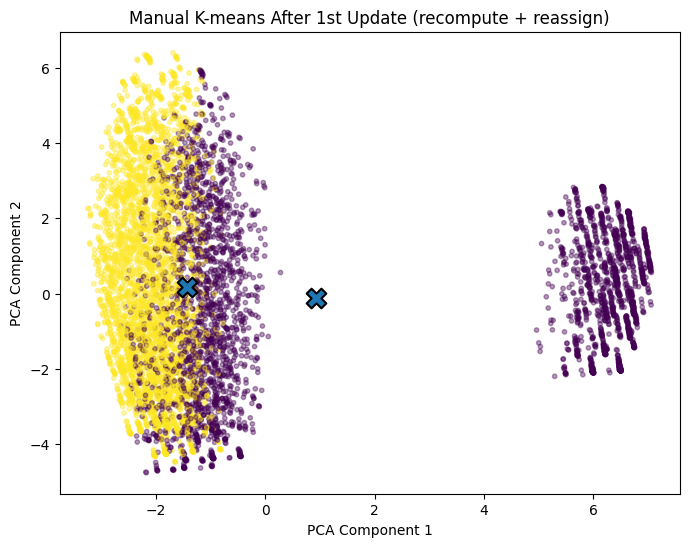

In [32]:
#2.4 Reassign points based on new centroids
distances_new = np.stack(
    [np.linalg.norm(X_manual - centroids_new[j], axis=1) for j in range(k)],
    axis=1
)

labels_new = np.argmin(distances_new, axis=1)

print("Cluster sizes after recomputing centroids:")
print(pd.Series(labels_new).value_counts())

#number of points that changed clusters
changes = np.sum(labels_new != labels_manual)
print(f"\nNumber of points that changed clusters: {changes}")

#plot
#resuse same pca projection
plt.figure(figsize=(8,6))

plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=labels_new, #updated labels
    alpha=0.4,
    s=10
)

#plot the new centroids in 2D
centroids_new_2d = pca.transform(centroids_new)
plt.scatter(
    centroids_new_2d[:,0], centroids_new_2d[:,1],
    marker='X',
    s=200,
    edgecolor='black',
    linewidth=1.5
)

plt.title("Manual K-means After 1st Update (recompute + reassign)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [35]:
#2.5.1 loop until convergence
#start with centroids and labels from steps 3 and 4 (for explicit starting point)
centroids = centroids_new
labels = labels_new

max_iters = 100

for iteration in range(max_iters):
    #recompute centroids
    centroids = np.array([
        X_manual[labels == j].mean(axis=0)
        for j in range(k)
    ])

    #reassign points
    distances = np.stack(
        [np.linalg.norm(X_manual - centroids[j], axis=1) for j in range(k)],
        axis=1
    )

    #compute new labels for iteration
    labels_new = np.argmin(distances, axis=1)

    #check for convergence (if labels change)
    if np.array_equal(labels_new, labels):
        print(f"Coverage after {iteration + 1} iterations.")
        break

    #if not converged, prepare for next iteration
    labels = labels_new

else:
    print("max_iters reached without convergence")

Coverage after 4 iterations.


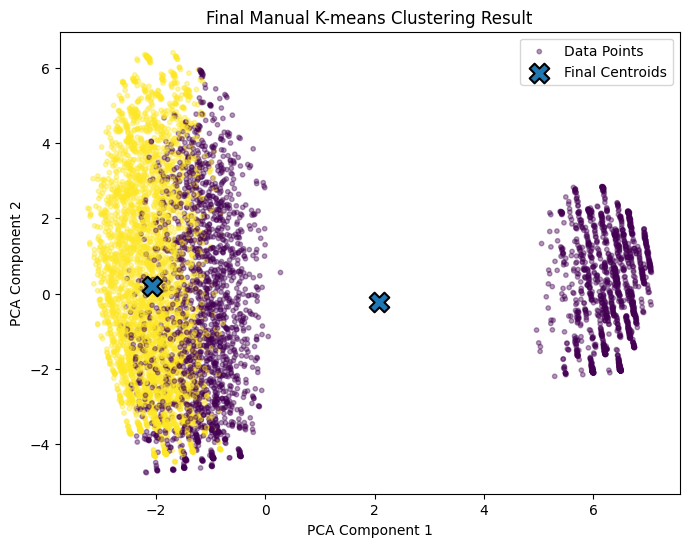

In [34]:
#2.5.2 plot
#project final centroids into the same PCA space
final_centroids_2d = pca.transform(centroids)

plt.figure(figsize=(8, 6))

#plot all points using final labels
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,
    alpha=0.4,
    s=10,
    label="Data Points"
)

#plot final centroids
plt.scatter(
    final_centroids_2d[:, 0],
    final_centroids_2d[:, 1],
    marker='X',
    s=200,
    edgecolor='black',
    linewidth=1.5,
    label="Final Centroids"
)

plt.title("Final Manual K-means Clustering Result")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [36]:
#4.1 choose k with Elbow Method + Silhouette Analysis
intertias = [] #sum of squared distances of points to centroids
silhoutes = [] #score between -1 and 1, high: close to own cluster, low/neg: clusters overlap (bad k)
k_values = range(2, 11) #choose a starting range

#loop over possible values for k
for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=1)
    #run kmeans algorithm (initialize centroids, assign points, recomputes centroids, loops to convergence)
    kmeans.fit(X_scaled)

    #store inertia (sum of squared distances between every point and centroid)
    inertias.append(kmeans.inertia_)
    labels_k = kmeans.labels_

    #compute inertia score. silhoute = (b-a)/max(a,b). a= ave distance other points, b ave distance to points in nearest cluster
    silhouettes.append(silhouette_score(X_scaled, labels_k))

inertias, silhouettes

In [ ]:
#4.2 silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, silhouettes, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores")

plt.tight_layout()
plt.show()